# Duelling Double Deep Q-Network (D3QN)

> Following up from [last article](https://sezan92.github.io/2020/03/18/DDQN.html). In the last blog I discussed about Double Deep Q Network. In this blog, I am discussing the more advanced version! Duelling Double Deep Q Network!

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import namedtuple,deque
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn
import torch
import torch.nn.functional as F
import torch.optim as optim


### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/floyd/home/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
state_shape= env.observation_space.shape[0]
action_size= env.action_space.n

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class DuellingQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64,fc3_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DuellingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units,fc3_units)
        self.fc4 = nn.Linear(fc3_units,64)
        self.valuefc=nn.Linear(64,64)
        self.valuefc2=nn.Linear(64,32)
        self.advfc=nn.Linear(64,64)
        self.advfc2=nn.Linear(64,32)
        self.value=nn.Linear(32,1)
        self.advantage = nn.Linear(32, action_size)
        

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        value_x=F.relu(self.valuefc(x))
        value_x=F.relu(self.valuefc2(value_x))
        adv_x=F.relu(self.advfc(x))
        adv_x=F.relu(self.advfc2(adv_x))
        value=self.value(value_x)
        advantage=self.advantage(adv_x)
        Q =value+advantage-torch.max(advantage)
        
        return value,advantage,Q

In [6]:

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.01              # for soft update of target parameters
LR = 0.001               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DuellingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuellingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        self.criterion=nn.MSELoss()
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            value,advantage,Q = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(Q.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## TODO: compute and minimize the loss
        "*** YOUR CODE HERE ***"
        
        target_values,target_advantages,target_Qs=self.qnetwork_target(next_states)
        _,_,Qs=self.qnetwork_local(states)
        _,_,next_state_Qs=self.qnetwork_local(next_states)
        predicted_actions=torch.argmax(next_state_Qs,1)
        predicted_actions=predicted_actions.reshape(-1,1)
        y=rewards+gamma*target_Qs.gather(1,predicted_actions)*(1-dones)
        #print(gamma*torch.max(self.qnetwork_target(next_states),1)[0]*(1-dones))
        loss=F.mse_loss(y,Qs.gather(1,actions))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:


agent = Agent(state_size=state_shape, action_size=action_size, seed=0)

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [9]:
n_episodes=1000
max_t=1000
eps_start=1.0
eps_end=0.1
eps_decay=0.995

In [10]:
def train_agent(agent,env,target_folder,eps_start=eps_start,eps_decay=eps_decay,eps_end=eps_end,gamma=GAMMA,n_episodes=n_episodes,max_t=max_t):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):

        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)

            agent.step(state, action, reward, next_state,done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode%10==0:
            torch.save(agent.qnetwork_local.state_dict(),"{}/dqn_agent{}.pkl".format(target_folder,i_episode))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
    return scores

In [11]:
scores_dddqn=train_agent(agent,env,target_folder="duelling_double_dqn/")

Episode 100	Average Score: -172.07
Episode 200	Average Score: -64.69
Episode 300	Average Score: 46.16
Episode 400	Average Score: 115.03
Episode 500	Average Score: 175.13
Episode 520	Average Score: 200.28
Environment solved in 420 episodes!	Average Score: 200.28
Episode 521	Average Score: 200.58
Environment solved in 421 episodes!	Average Score: 200.58
Episode 522	Average Score: 200.49
Environment solved in 422 episodes!	Average Score: 200.49
Episode 567	Average Score: 200.08
Environment solved in 467 episodes!	Average Score: 200.08
Episode 568	Average Score: 200.45
Environment solved in 468 episodes!	Average Score: 200.45
Episode 569	Average Score: 203.26
Environment solved in 469 episodes!	Average Score: 203.26
Episode 570	Average Score: 203.18
Environment solved in 470 episodes!	Average Score: 203.18
Episode 571	Average Score: 201.89
Environment solved in 471 episodes!	Average Score: 201.89
Episode 572	Average Score: 201.77
Environment solved in 472 episodes!	Average Score: 201.77
Ep

In [12]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
scores_ma_d3qn=moving_average(scores_dddqn,n=100)

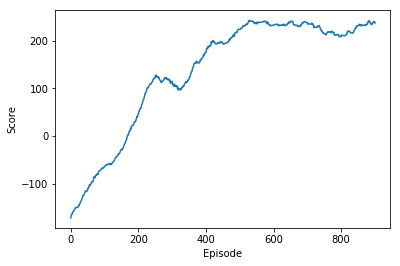

In [16]:
# plot the scores
plt.plot(np.arange(len(scores_ma_d3qn)), scores_ma_d3qn)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

<a id="compare"></a>
### Let's compare with the DQN and DDQN? 

In [17]:
scores_dqn_with_target=np.loadtxt("dqn_with_target/scores.txt")
scores_dqn_no_target=np.loadtxt("dqn_no_target/scores.txt")
scores_ddqn=np.loadtxt("double_dqn/scores.txt")

In [18]:
scores_ma_dqn_no_target=moving_average(scores_dqn_no_target,n=100)
scores_ma_dqn_with_target=moving_average(scores_dqn_with_target,n=100)
scores_ma_ddqn=moving_average(scores_ddqn,n=100)

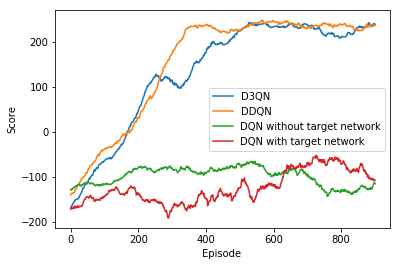

In [19]:
plt.plot(np.arange(len(scores_ma_d3qn)), scores_ma_d3qn,label="D3QN")
plt.plot(np.arange(len(scores_ma_ddqn)), scores_ma_ddqn,label="DDQN")
plt.plot(np.arange(len(scores_ma_dqn_no_target)), scores_ma_dqn_no_target,label="DQN without target network")
plt.plot(np.arange(len(scores_ma_dqn_with_target)), scores_ma_dqn_with_target,label="DQN with target network")
plt.ylabel('Score')
plt.xlabel('Episode ')
plt.legend()